In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from community import community_louvain

In [ ]:
from dataloader import DataLoader
loader = DataLoader(hs_code=282520)

In [5]:
polar_df = loader.get_data()
df = polar_df.to_pandas()

years = sorted(df['t'].unique())

In [8]:

##############################################
# Helper Functions
##############################################
def compute_diameter(G):
    if G.number_of_nodes() == 0:
        return np.nan
    if nx.is_connected(G):
        return nx.diameter(G)
    else:
        GCC = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(GCC)
        if G_sub.number_of_nodes() > 1:
            return nx.diameter(G_sub)
        else:
            return 0.0

def compute_degree_assortativity(G):
    if G.number_of_edges() > 0:
        return nx.degree_assortativity_coefficient(G, x='degree')
    else:
        return np.nan

def compute_avg_node_strength(G):
    if G.number_of_nodes() == 0:
        return np.nan
    strengths = []
    for n in G.nodes():
        strength = sum(d['weight'] for _,_,d in G.edges(n, data=True))
        strengths.append(strength)
    if len(strengths) > 0:
        return np.mean(strengths)
    else:
        return np.nan

def gini_coefficient(values):
    arr = np.sort(values)
    n = len(arr)
    if n == 0:
        return np.nan

    cumulative = np.cumsum(arr)
    sum_arr = cumulative[-1]
    if sum_arr == 0:
        return 0.0

    rel_cumulative = cumulative / sum_arr
    return (n+1 - 2*np.sum(rel_cumulative)/n)

def compute_gini_node_strength(G):
    if G.number_of_nodes() == 0:
        return np.nan
    strengths = [sum(d['weight'] for _,_,d in G.edges(n, data=True)) for n in G.nodes()]
    if len(strengths) == 0:
        return np.nan
    return gini_coefficient(strengths)

def compute_fraction_bridges(G):
    if G.number_of_edges() == 0:
        return 0.0
    bridges = list(nx.bridges(G))
    return len(bridges) / G.number_of_edges()


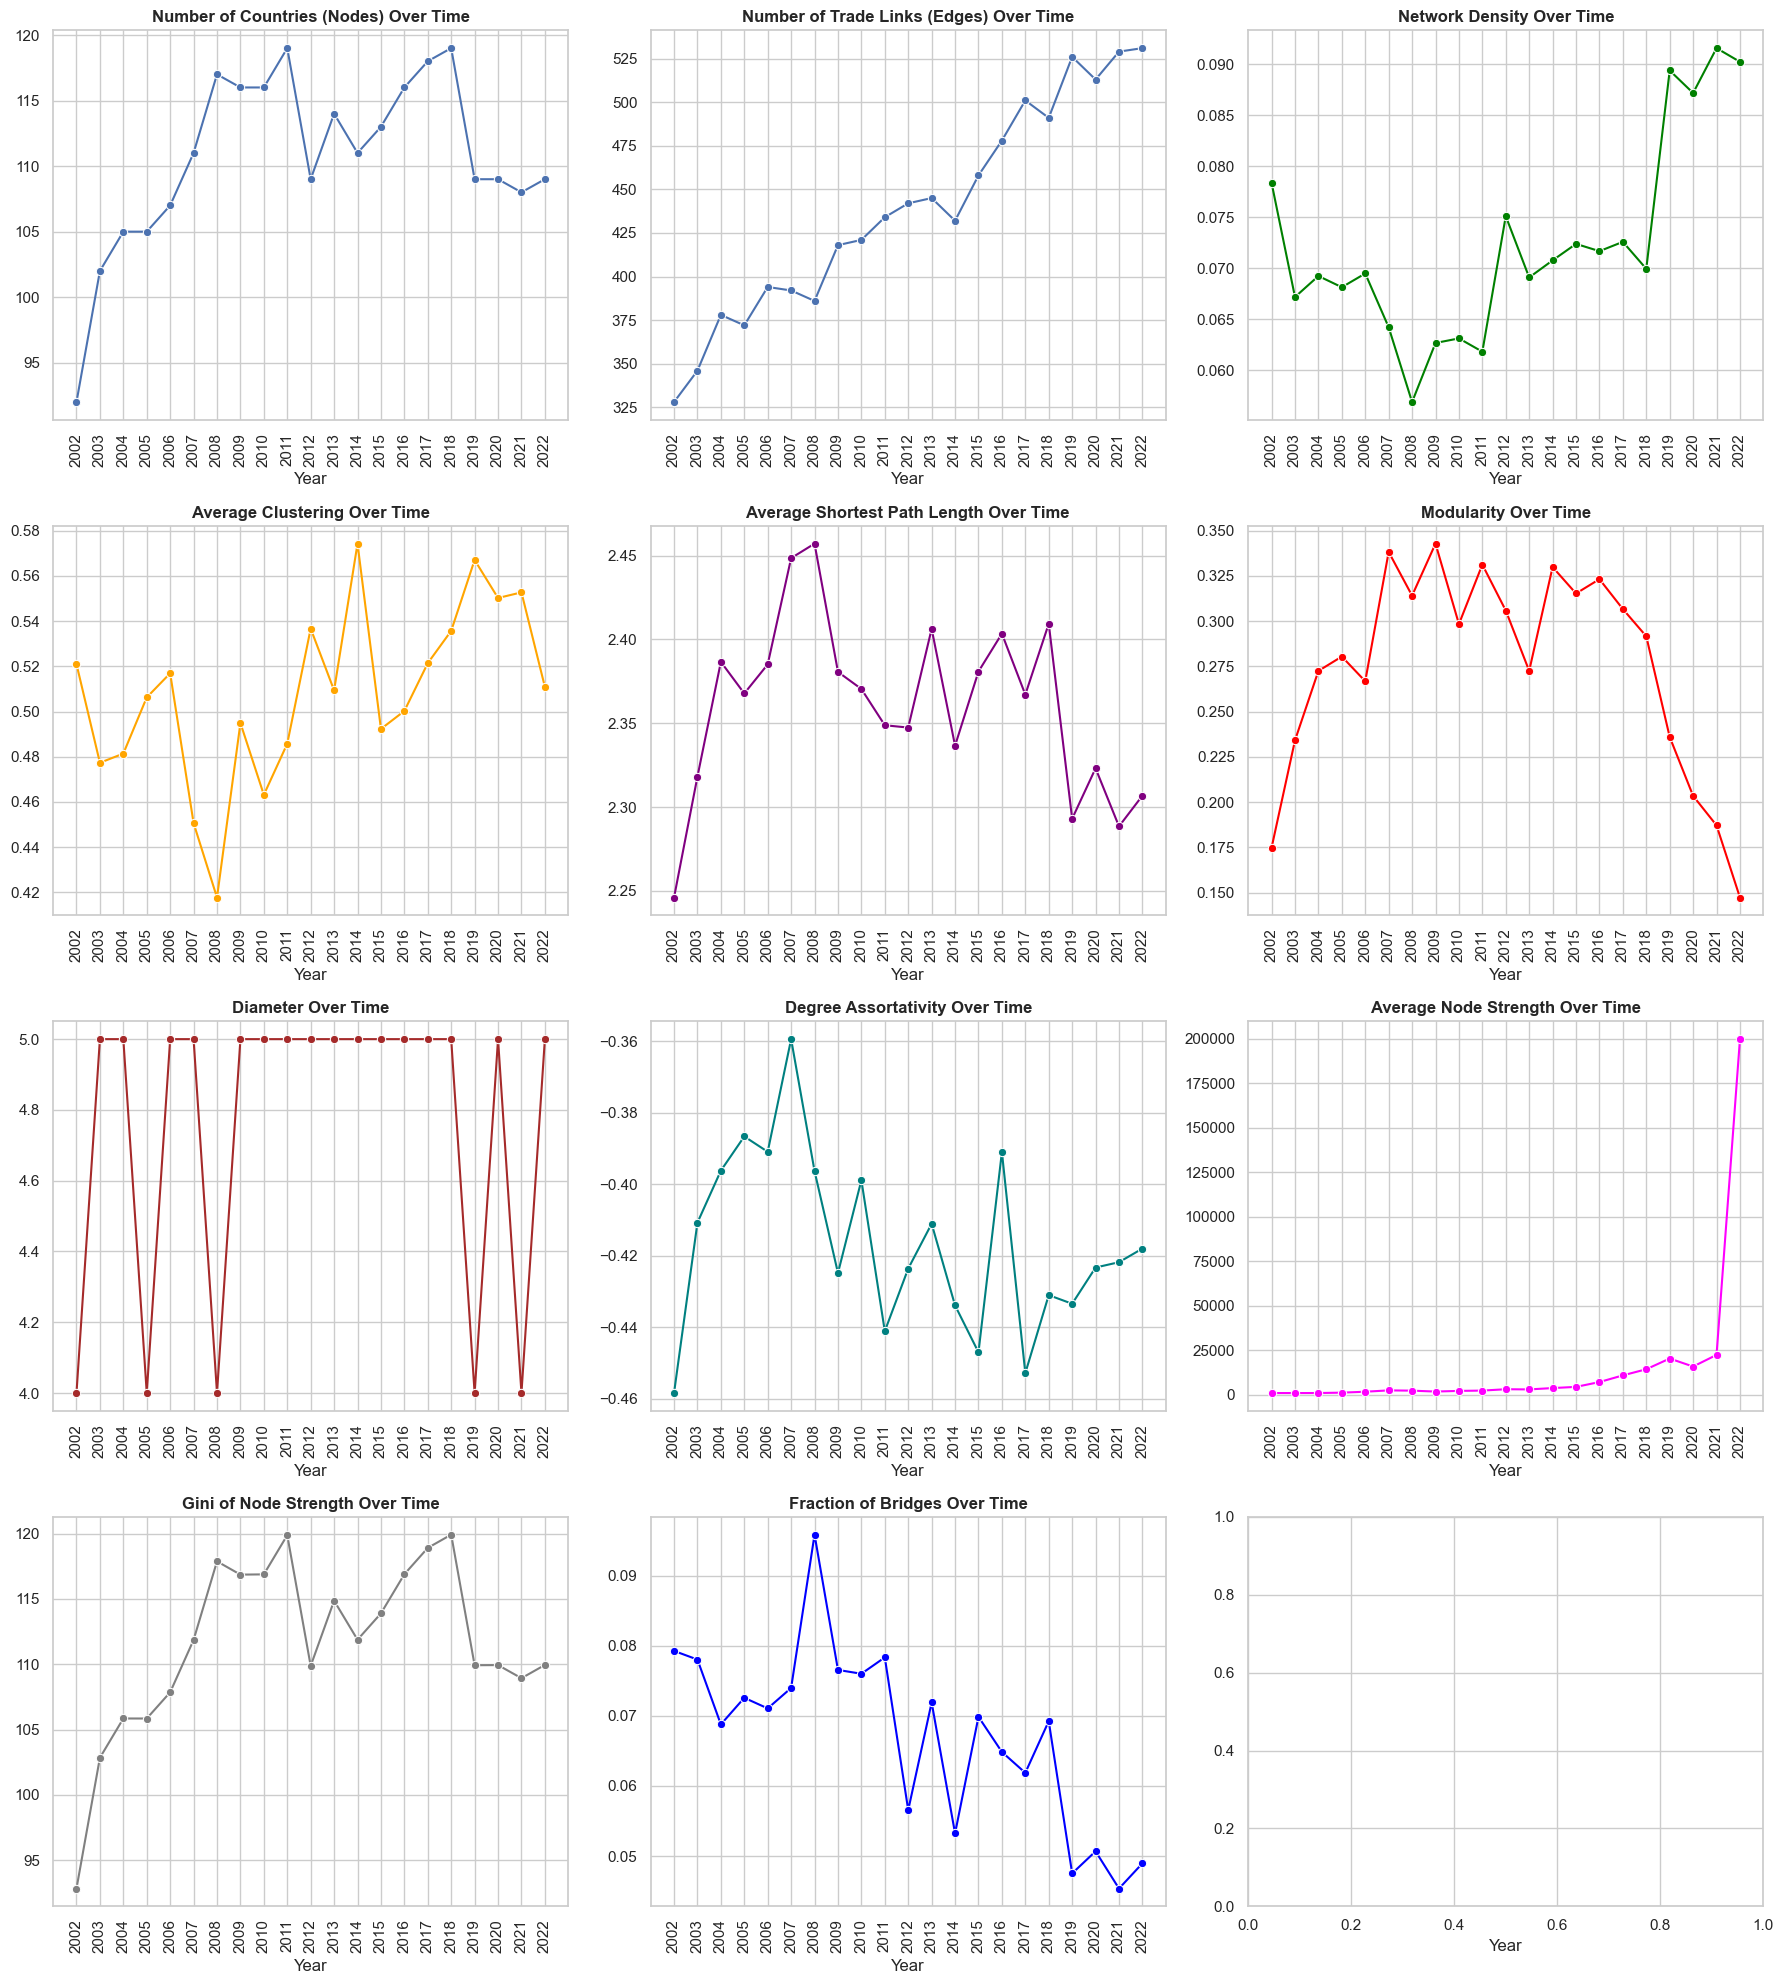

In [9]:



##############################################
# Building Yearly Graphs
##############################################
yearly_graphs = {}
for y in years:
    df_year = df[df['t'] == y]
    df_agg = df_year.groupby(['export_country','import_country'], as_index=False)['v'].sum()
    G = nx.Graph()
    for _, row in df_agg.iterrows():
        exporter = row['export_country']
        importer = row['import_country']
        value = row['v']
        if exporter != importer:
            if G.has_edge(exporter, importer):
                G[exporter][importer]['weight'] += value
            else:
                G.add_edge(exporter, importer, weight=value)
    yearly_graphs[y] = G

##############################################
# Network Metrics Over Time
##############################################
results = {
    'year': [],
    'num_nodes': [],
    'num_edges': [],
    'density': [],
    'avg_clustering': [],
    'avg_shortest_path': [],
    'modularity': [],
    'num_communities': [],
    'diameter': [],
    'degree_assortativity': [],
    'avg_node_strength': [],
    'gini_node_strength': [],
    'fraction_bridges': [],
}

for y, G in yearly_graphs.items():
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    density = nx.density(G)

    # Average Clustering Coefficient
    avg_clustering = nx.average_clustering(G)

    # Average shortest path length
    if nx.is_connected(G):
        avg_sp = nx.average_shortest_path_length(G)
    else:
        GCC = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(GCC)
        avg_sp = nx.average_shortest_path_length(G_sub)

    # Community Detection
    partition = community_louvain.best_partition(G, weight='weight')
    mod = community_louvain.modularity(partition, G, weight='weight')
    num_com = len(set(partition.values()))

    # Diameter
    diameter = compute_diameter(G)

    # Degree Assortativity
    degree_assort = compute_degree_assortativity(G)

    # Average Node Strength
    avg_strength = compute_avg_node_strength(G)

    # Gini Coefficient of Node Strength
    gini_strength = compute_gini_node_strength(G)

    # Fraction Bridges
    frac_bridges = compute_fraction_bridges(G)

    results['year'].append(y)
    results['num_nodes'].append(num_nodes)
    results['num_edges'].append(num_edges)
    results['density'].append(density)
    results['avg_clustering'].append(avg_clustering)
    results['avg_shortest_path'].append(avg_sp)
    results['modularity'].append(mod)
    results['num_communities'].append(num_com)
    results['diameter'].append(diameter)
    results['degree_assortativity'].append(degree_assort)
    results['avg_node_strength'].append(avg_strength)
    results['gini_node_strength'].append(gini_strength)
    results['fraction_bridges'].append(frac_bridges)

results_df = pd.DataFrame(results)



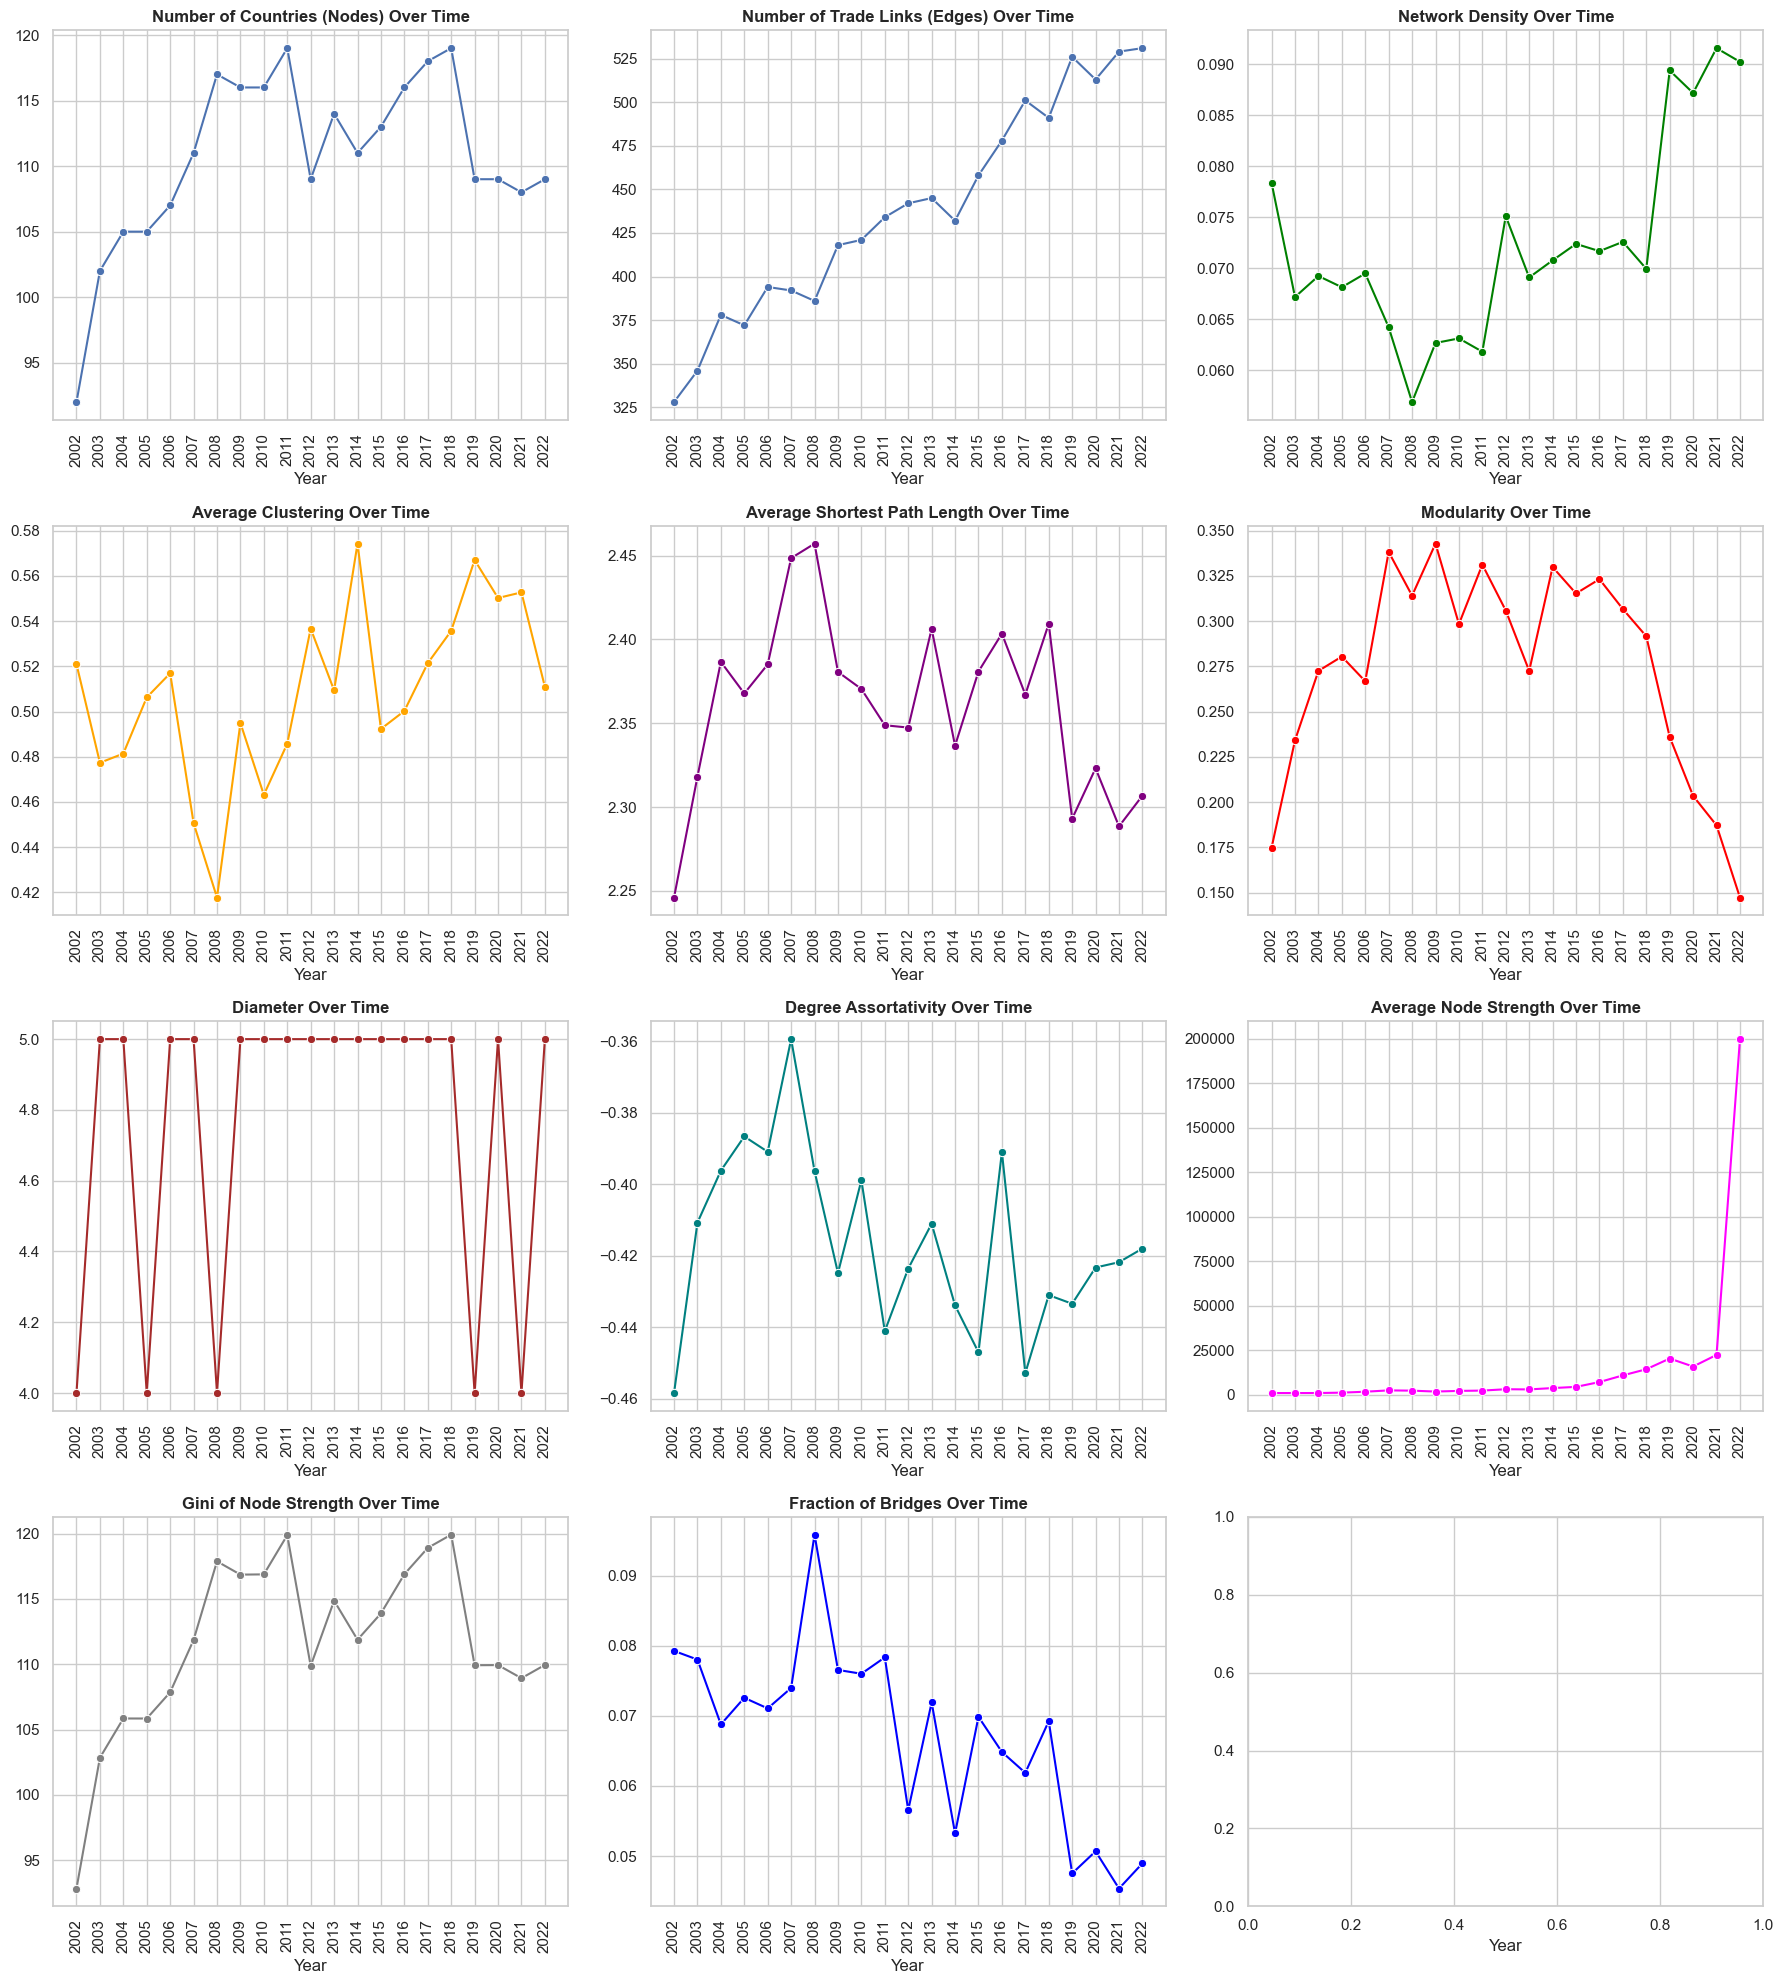

In [10]:
##############################################
# Visualization
##############################################
sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(4, 3, figsize=(18, 20))
axs = axs.flatten()

sns.lineplot(data=results_df, x='year', y='num_nodes', ax=axs[0], marker='o')
axs[0].set_title("Number of Countries (Nodes) Over Time", fontweight="bold")
axs[0].set_xticks(results_df["year"].unique().astype(int))
axs[0].tick_params(axis='x', labelrotation=90)

sns.lineplot(data=results_df, x='year', y='num_edges', ax=axs[1], marker='o')
axs[1].set_title("Number of Trade Links (Edges) Over Time", fontweight="bold")
axs[1].set_xticks(results_df["year"].unique().astype(int))
axs[1].tick_params(axis='x', labelrotation=90)

sns.lineplot(data=results_df, x='year', y='density', ax=axs[2], marker='o', color='green')
axs[2].set_title("Network Density Over Time", fontweight="bold")
axs[2].set_xticks(results_df["year"].unique().astype(int))
axs[2].tick_params(axis='x', labelrotation=90)

sns.lineplot(data=results_df, x='year', y='avg_clustering', ax=axs[3], marker='o', color='orange')
axs[3].set_title("Average Clustering Over Time", fontweight="bold")
axs[3].set_xticks(results_df["year"].unique().astype(int))
axs[3].tick_params(axis='x', labelrotation=90)

sns.lineplot(data=results_df, x='year', y='avg_shortest_path', ax=axs[4], marker='o', color='purple')
axs[4].set_title("Average Shortest Path Length Over Time", fontweight="bold")
axs[4].set_xticks(results_df["year"].unique().astype(int))
axs[4].tick_params(axis='x', labelrotation=90)

sns.lineplot(data=results_df, x='year', y='modularity', ax=axs[5], marker='o', color='red')
axs[5].set_title("Modularity Over Time", fontweight="bold")
axs[5].set_xticks(results_df["year"].unique().astype(int))
axs[5].tick_params(axis='x', labelrotation=90)

sns.lineplot(data=results_df, x='year', y='diameter', ax=axs[6], marker='o', color='brown')
axs[6].set_title("Diameter Over Time", fontweight="bold")
axs[6].set_xticks(results_df["year"].unique().astype(int))
axs[6].tick_params(axis='x', labelrotation=90)

sns.lineplot(data=results_df, x='year', y='degree_assortativity', ax=axs[7], marker='o', color='teal')
axs[7].set_title("Degree Assortativity Over Time", fontweight="bold")
axs[7].set_xticks(results_df["year"].unique().astype(int))
axs[7].tick_params(axis='x', labelrotation=90)

sns.lineplot(data=results_df, x='year', y='avg_node_strength', ax=axs[8], marker='o', color='magenta')
axs[8].set_title("Average Node Strength Over Time", fontweight="bold")
axs[8].set_xticks(results_df["year"].unique().astype(int))
axs[8].tick_params(axis='x', labelrotation=90)

sns.lineplot(data=results_df, x='year', y='gini_node_strength', ax=axs[9], marker='o', color='gray')
axs[9].set_title("Gini of Node Strength Over Time", fontweight="bold")
axs[9].set_xticks(results_df["year"].unique().astype(int))
axs[9].tick_params(axis='x', labelrotation=90)

sns.lineplot(data=results_df, x='year', y='fraction_bridges', ax=axs[10], marker='o', color='blue')
axs[10].set_title("Fraction of Bridges Over Time", fontweight="bold")
axs[10].set_xticks(results_df["year"].unique().astype(int))
axs[10].tick_params(axis='x', labelrotation=90)

for ax in axs:
    ax.set_xlabel("Year")
    ax.set_ylabel("")
    ax.grid(True)

plt.tight_layout()
plt.show()